In [1]:
import torch
import pandas as pd
import numpy as np
from data_loader import CustomSignalData, CustomSignalData1
from torch.autograd import Variable
import matplotlib.pyplot as plt
from encoder import Encoder as E
from helpers import get_data, get_all_data, get_shift_data, get_operators, plot_cfs_mat, roll_data

AttributeError: module 'numpy' has no attribute 'typeDict'

In [5]:
DEVICE = torch.device("cpu")

# Data Import

In [6]:
X_train, y_train, X_test, y_test = get_data()
X_train.shape, X_test.shape

((794, 8), (806, 8))

In [7]:
all_X_train, all_y_train, all_shift_train = get_all_data(X_train, y_train)
all_X_test, all_y_test, all_shift_test = get_all_data(X_test, y_test)
all_X_train.shape, all_X_test.shape

((6352, 8), (6448, 8))

In [8]:
all_X1_train, all_X2_train, all_shift_1_train, all_shift_2_train, all_y_shift_train = get_shift_data(all_X_train, all_shift_train, all_y_train)
all_X1_test, all_X2_test, all_shift_1_test, all_shift_2_test, all_y_shift_test = get_shift_data(all_X_test, all_shift_test, all_y_test)

all_X1_train.shape, all_X1_test.shape

((6352, 8), (6448, 8))

# Data Loader 

In [9]:
def get_tensor(arr):
    return torch.tensor(arr, device=DEVICE,dtype=torch.float )

In [10]:
traindataset = CustomSignalData(get_tensor(X_train), get_tensor(y_train))
#testdataset = CustomSignalData(get_tensor(X_test), get_tensor(y_test))

trainloader = torch.utils.data.DataLoader(traindataset, batch_size = 1, shuffle=True)
#testloader = torch.utils.data.DataLoader(testdataset, batch_size=24, shuffle=True)

all_train_dataset = CustomSignalData(get_tensor(all_X_train), get_tensor(all_y_train))
alltrainloader = torch.utils.data.DataLoader(all_train_dataset, batch_size = 102, shuffle=True)

triplet_train_dataset = CustomSignalData1(get_tensor(all_X1_train), get_tensor(all_X2_train), get_tensor(all_shift_1_train), get_tensor(all_shift_2_train), get_tensor(all_y_shift_train))
triplettrainloader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size = 102, shuffle=True)

#all_test_dataset = CustomSignalData(get_tensor(all_X_test), get_tensor(all_y_test))
#alltestloader = torch.utils.data.DataLoader(all_test_dataset, batch_size = 100, shuffle=True)

#triplet_test_dataset = CustomSignalData1(get_tensor(all_X1_test), get_tensor(all_X2_test), get_tensor(all_shift_1_test), get_tensor(all_shift_2_test), get_tensor(all_y_shift_test))
#triplettestloader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size = 100, shuffle=True)


# Operator

In [11]:
M = torch.diag(torch.ones(8)).roll(-1,1)
used_bases = [torch.linalg.matrix_power(M,i).to(DEVICE) for i in range (8)]

In [12]:
def rotate_batch(x, d, out_features):
  rotated = torch.empty(x.shape, device=DEVICE)
  for i in range (x.shape[0]):
    rotated[i] = used_bases[d[i]].matmul(x[i]) 
  return rotated

# Loss calculation

In [13]:
def clf_acc(model, loader, masks = None, encoder = None):
    model.eval()
    correct = 0
    iter = 0
    with torch.no_grad():
        for inputs, labels,_,_ in loader:
            inputs = inputs.to(DEVICE)
            if masks is not None:
                inputs = inputs * masks[:inputs.size()[0]]
            labels = labels.to(DEVICE)
            labels = labels.flatten()
            if encoder:
                pred = model(inputs, encoder)
            else:
                pred = model(inputs)
            correct += (1-torch.abs(torch.sign(torch.argmax(pred,dim = 1)- labels))).mean().item()
            iter += 1
    return correct/iter
            

In [14]:
# This function computes the accuracy on the test dataset
def compute_accuracy(a, b, loader):
    a.eval()
    b.eval()
    
    correct = 0
    iter = 0
    
    with torch.no_grad():
        for inputs1, inputs2, shift1, shift2, labels, _ in loader:
            inputs1 = inputs1.to(DEVICE)
            inputs2 = inputs2.to(DEVICE)
            shift1 = -shift1.int().flatten().to(DEVICE)
            shift2 = -shift2.int().flatten().to(DEVICE)
            labels = labels.flatten().to(DEVICE)
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            y1 = a(inputs1)
            y_tr_est1 = rotate_batch(y1,shift1,6)
            y_tr1 = b(y_tr_est1)

            y2 = a(inputs2)
            y_tr_est2 = rotate_batch(y2,shift1,6)
            y_tr2 = b(y_tr_est2)

            correct += (1-torch.abs(torch.sign(torch.argmax(y_tr1,dim = 1)- labels))).mean().item() + \
                    (1-torch.abs(torch.sign(torch.argmax(y_tr2,dim = 1)- labels))).mean().item()
            iter += 1
    return correct * 0.5 / iter

# Training loop

## Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression(random_state=0, penalty='l2', # LASSO
                                solver='liblinear', C= 1000, # Suitable for LASSO
                                max_iter=5000).fit(all_X_train, all_y_train)
reg.score(all_X_train,all_y_train)

/home/ros-lab/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.4760705289672544

In [16]:
accuracies = []
for i in range (-4, 4):
    X_test_shift = roll_data(X_train, i)
    accuracies.append(reg.score(X_test_shift,y_train))

## Feed forward Neural Network

In [17]:
import torch
from torch.autograd import Variable
class FFNN(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(FFNN, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(inputSize, 9, bias=False),
            torch.nn.Sigmoid()
        )
        self.classifer = torch.nn.Sequential(
            torch.nn.Linear(9, outputSize, bias=False),
            # torch.nn.Softmax(dim=1)
        )

    def forward(self, x, encoder=None):
        if not encoder:
            encoder = self.encoder
        z = encoder(x)
        class_z = self.classifer(z)

        return class_z

In [18]:
inputDim = 8     # takes variable 'x' 
outputDim = 3      # takes variable 'y'
learningRate = 0.005

model = FFNN(inputDim, outputDim)
model = model.to(DEVICE)


In [19]:
crit = torch.nn.CrossEntropyLoss()
acc_record = []
params_clf = list(model.parameters())# + list(encoder.parameters())
optim = torch.optim.Adam(params_clf, lr=learningRate)

In [20]:
DEVICE = torch.device("cpu")

In [21]:
epochs = 200
#encoder = encoder.to(device)
for epoch in range(epochs):
    model.train()

    # Converting inputs and labels to Variable
    for inputs, labels, _, _ in alltrainloader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        labels = labels.long()
        labels = labels.flatten()
        outputs = model(inputs, None)
        optim.zero_grad()
        # get loss for the predicted output
        losss = crit(outputs, labels) #+ 0.001 * model.l1_regula()
        # get gradients w.r.t to parameters
        losss.backward()
        # update parameters
        optim.step()

    if not epoch %20:
        train_acc = clf_acc(model, alltrainloader,encoder= None)
        #test_acc = clf_acc(model, alltestloader, encoder = None)
        acc_record += [train_acc]# [(train_acc, test_acc)]
    if not epoch % 20:
        print('epoch {}, train {:.4} test'.format(epoch, train_acc))#, test_acc))

epoch 0, train 0.3303 test


epoch 20, train 0.476 test
epoch 40, train 0.5038 test
epoch 60, train 0.4782 test
epoch 80, train 0.4632 test
epoch 100, train 0.4776 test
epoch 120, train 0.5013 test
epoch 140, train 0.4926 test
epoch 160, train 0.4967 test
epoch 180, train 0.474 test


In [22]:
accuracies_ffnn = []
for i in range (-4, 4):
    X_test_shift = roll_data(X_train, i)
    test_shift_dataset = CustomSignalData(get_tensor(X_test_shift), get_tensor(y_train))
    testshiftloader = torch.utils.data.DataLoader(test_shift_dataset, batch_size=24, shuffle=True)
    accuracies_ffnn.append(clf_acc(model, testshiftloader, encoder = None))


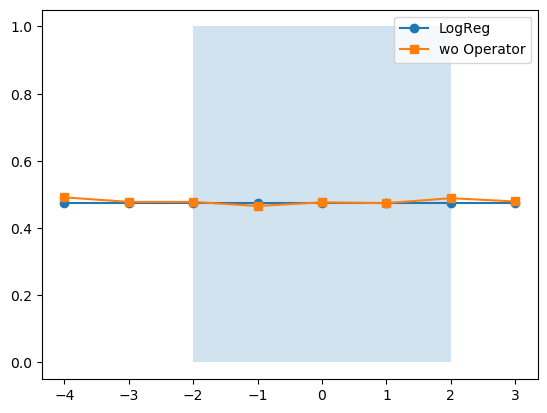

In [23]:
#plt.plot(range(-15,16),accuracies, '-o', label="Logistic Reg")
#plt.plot(range(-15,16),accuracies_distort, '-s', label="Logistic Reg, distorted")
plt.plot(range(-4,4),accuracies, '-o', label="LogReg")
plt.plot(range(-4,4),accuracies_ffnn, '-s', label="wo Operator")
plt.fill_between(range(-2,3), 0,1, alpha=0.2)
plt.legend()

In [24]:
torch.save(model.state_dict(), "modelwoOperator.pt")

## Self-supervised

### Learned operator

In [25]:
import torch
import torch.nn as nn

class Operator(nn.Module):
    def __init__(self, in_features, n_rotations):
        super(Operator, self).__init__()
        """
        Args:
          in_features (int): Number of input features which should be equal to xsize.
          out_features (out): Number of output features which should be equal to ysize.
        """
        self.in_features = in_features
        self.core = torch.nn.Parameter(torch.zeros(3*self.in_features**2)- 0*torch.diag(torch.rand(3*self.in_features**2)/10))
        self.core.requires_grad = True
        self.n_rotations = n_rotations
        
    def rotate_batch(self, x, d, out_features):
      rotated = torch.empty(x.shape[0], 3*out_features*out_features, device=DEVICE)
      phies = [torch.linalg.matrix_power(self.core,i).to(DEVICE) for i in range (0,self.n_rotations+0)]
      for i in range (x.shape[0]):
        rotated[i] = phies[(d[i]+0)%4].matmul(x[i]) 
      return rotated

    def forward(self, x, d):
        """
        Args:
          x of shape (batch_size, 3, xsize, xsize): Inputs.
        
        Returns:
          y of shape (batch_size, 3*xsize^2): Outputs.
        """
        z = self.rotate_batch(x, d, self.in_features)
        return z

### Training

In [26]:
DEVICE = torch.device("cpu")

In [27]:
encoder = E(8,8)
encoder.to(DEVICE)
classifier = FFNN(8,3)
classifier.to(DEVICE)

parameters = list(encoder.parameters()) + list(classifier.parameters())

crit1 = torch.nn.MSELoss()
crit2 = torch.nn.CrossEntropyLoss()
crit1.to(DEVICE)
crit2.to(DEVICE)
loss_record = []

In [28]:
import torch.optim as optim
optimizer = optim.Adam(parameters, lr=0.002)

In [29]:
n_epochs = 50

for epoch in range(0,n_epochs):
  encoder.train()
  classifier.train()
  for inputs1, inputs2, shift1, shift2, labels, _ in triplettrainloader:
    inputs1 = inputs1.to(DEVICE)
    inputs2 = inputs2.to(DEVICE)
    shift1 = -shift1.int().flatten().to(DEVICE)
    shift2 = -shift2.int().flatten().to(DEVICE)
    labels = labels.long().flatten().to(DEVICE)
    # zero the parameter gradients
    optimizer.zero_grad()
      
    # forward + backward + optimize
    y1 = encoder(inputs1)
    y_tr_est1 = rotate_batch(y1,shift1,6)
    y_tr1 = classifier(y_tr_est1)


    y2 = encoder(inputs2)
    y_tr_est2 = rotate_batch(y2,shift2,6)
    y_tr2 = classifier(y_tr_est2)

    loss =  crit1(y_tr_est1, y_tr_est2) + 0.5*crit2(y_tr1,labels)+ 0.5*crit2(y_tr2,labels)
    loss.backward()
    optimizer.step()
    
  if not epoch %5:
    train_loss = compute_accuracy(encoder, classifier, triplettrainloader)
    test_loss = 0.005# compute_accuracy(encoder, classifier, triplettestloader)
    loss_record +=  [(train_loss, test_loss)]
    print("Epoch {}/{}: train error {:.4} test error {:.4}".format(epoch, n_epochs,train_loss, test_loss))

Epoch 0/50: train error 0.3398 test error 0.005
Epoch 5/50: train error 0.5631 test error 0.005
Epoch 10/50: train error 0.5934 test error 0.005
Epoch 15/50: train error 0.6039 test error 0.005
Epoch 20/50: train error 0.6288 test error 0.005
Epoch 25/50: train error 0.6329 test error 0.005
Epoch 30/50: train error 0.6319 test error 0.005
Epoch 35/50: train error 0.6327 test error 0.005
Epoch 40/50: train error 0.6331 test error 0.005
Epoch 45/50: train error 0.6358 test error 0.005


In [30]:
torch.save(classifier.state_dict(), "classifier.pt")
torch.save(encoder.state_dict(), "encoder.pt")

In [31]:
accuracies_operator = []
for i in range (-4, 4):
    X_test_shift = roll_data(X_train, i)
    y1 = encoder(get_tensor(X_test_shift))
    y_tr_est1 = rotate_batch(y1, -torch.ones(X_test_shift.shape[0]).int() * i,6)
    y_tr1 = classifier(y_tr_est1)
    accuracies_operator.append((1-torch.abs(torch.sign(torch.argmax(y_tr1,dim = 1)- get_tensor(y_train).flatten()))).mean())


In [32]:
with torch.no_grad():
    encoder.eval()
    N_points = 1000
    rand_idx = np.random.choice(all_X_train.shape[0], N_points)
    y_tr = encoder(get_tensor(all_X_train[rand_idx]))
    recovered_points_ = rotate_batch(y_tr,-all_shift_train[rand_idx].flatten(), 6)
    del y_tr
    

In [33]:
torch.save(recovered_points_, "reference_points.pt")


In [34]:
with torch.no_grad():
    encoder.eval()
    N_points = 1000
    rand_idx = np.random.choice(all_X_train.shape[0], N_points)
    y_tr = encoder(get_tensor(all_X_train[rand_idx]))
    recovered_points_ = rotate_batch(y_tr,-all_shift_train[rand_idx].flatten(), 6)
    del y_tr
    
    accuracies_inferred_operator = []
    for i in range (-4, 4):
        X_test_shift = roll_data(X_train, i)
        y1 = encoder(get_tensor(X_test_shift))
        y_tr_rotated = torch.zeros(X_test_shift.shape[0])
        for j, y_ in enumerate(y1):
            distances = np.zeros(8)
            for d in (range(-4,4)):
                x_rotated = used_bases[d].matmul(y_).repeat(N_points,1)
                distances[d] = ((x_rotated-recovered_points_)**2).mean(1).topk(2, largest=False)[0].mean()
            y_tr_rotated[j] = distances.argmin()
        y_tr_est1 = rotate_batch(y1, y_tr_rotated.int(),6)
        y_tr1 = classifier(y_tr_est1).argmax(1)
        accuracies_inferred_operator.append((1-torch.abs(torch.sign(y_tr1- get_tensor(y_train).flatten()))).mean())


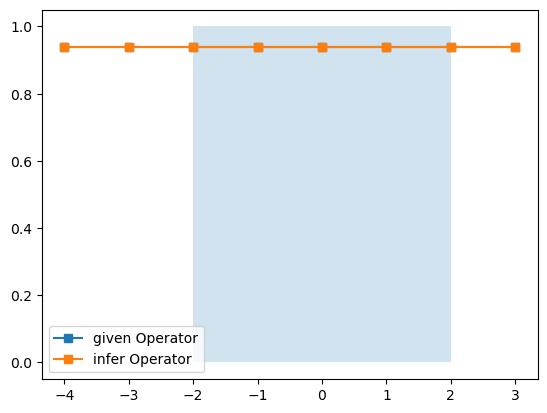

In [35]:
#plt.plot(range(-15,16),accuracies, '-o', label="Logistic Reg")
#plt.plot(range(-15,16),accuracies_distort, '-s', label="Logistic Reg, distorted")
#plt.plot(range(-4,4),accuracies, '-o', label="LogReg")
#plt.plot(range(-4,4),accuracies_ffnn, '-s', label="wo Operator")
plt.plot(range(-4,4),accuracies_operator, '-s', label="given Operator")
plt.plot(range(-4,4),accuracies_inferred_operator, '-s', label="infer Operator")

plt.fill_between(range(-2,3), 0,1, alpha=0.2)
plt.legend()

In [36]:
with torch.no_grad():
    encoder.eval()
    N_points = 1000
    rand_idx = np.random.choice(all_X_train.shape[0], N_points)
    y_tr = encoder(get_tensor(all_X_train[rand_idx]))
    recovered_points_ = rotate_batch(y_tr,-all_shift_train[rand_idx].flatten(), 6)
    del y_tr

In [37]:
with torch.no_grad():
    encoder.eval()
    N_points = 1000
    rand_idx = np.random.choice(all_X_train.shape[0], N_points)
    y_tr = encoder(get_tensor(all_X_train[rand_idx]))
    recovered_points_ = rotate_batch(y_tr,-all_shift_train[rand_idx].flatten(), 6)
    del y_tr
    
accuracies_inferred_operator = []
for i in range (-4, 4):
    X_test_shift = roll_data(X_test, i)
    y1 = encoder(get_tensor(X_test_shift))
    y_tr_rotated = torch.zeros(X_test_shift.shape[0])
    for j, y_ in enumerate(y1):
        distances = np.zeros(8)
        for d in (range(-4,4)):
            x_rotated = used_bases[d].matmul(y_).repeat(N_points,1)
            distances[d] = ((x_rotated-recovered_points_)**2).mean(1).topk(2, largest=False)[0].mean()
        y_tr_rotated[j] = distances.argmin()
    y_tr_est1 = rotate_batch(y1, y_tr_rotated.int(),6)
    y_tr1 = classifier(y_tr_est1).argmax(1)
    print(y_tr1- get_tensor(y_test).flatten())
    accuracies_inferred_operator.append((1-torch.abs(torch.sign(y_tr1- get_tensor(y_test).flatten()))).mean())


tensor([ 0.,  0.,  0.,  2.,  2.,  0.,  2.,  0.,  2.,  2.,  2.,  2.,  2.,  2.,
         2.,  2.,  0.,  2.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  2.,  2.,  0.,  0.,  0.,  0.,  0.,  2.,
         2.,  2.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  2.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  2.,  2.,  2.,
         0.,  0.,  0.,  0.,  0.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  

KeyboardInterrupt: 

In [ ]:
accuracies_inferred_operator

[tensor(0.8295),
 tensor(0.8446),
 tensor(0.8384),
 tensor(0.8414),
 tensor(0.8403),
 tensor(0.8442),
 tensor(0.8423),
 tensor(0.8228)]

In [ ]:
torch.save(encoder.state_dict(), 'encoder_2.pt')
torch.save(projection.state_dict(), 'projection_2.pt')

tensor(0.2293)

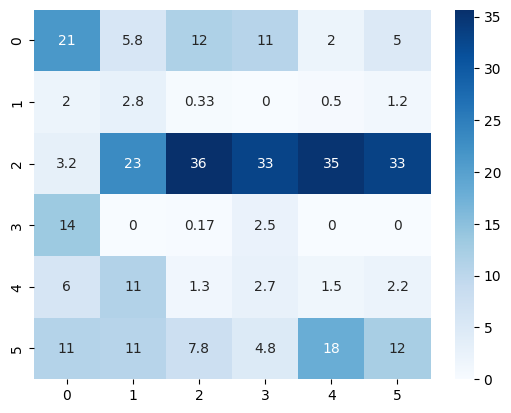

In [ ]:
encoder.eval()
centroids = torch.zeros(6, 192)
first = torch.zeros(6)
counts = torch.zeros(6,1)
for inputs, _, labels in trainloader:
    inputs = inputs.to(DEVICE).flatten()
    labels = labels.flatten()[0].int()
    y_tr = encoder(inputs)
    if first[labels-1]:
        centroids[labels-1] += y_tr
    else:
        centroids[labels-1] = y_tr
        first[labels-1] = 1
    counts[labels-1] +=1
centroids /= counts

inputs = get_tensor(X_test) 
y_tr = encoder(inputs)
distt = torch.zeros(X_test.shape[0], 6)
for i in range(6):
    distt[:, i] = ((y_tr-centroids[i])**2).mean(1)
plot_cfs_mat(distt.argmin(1),  y_test.astype('int').flatten()-1)
1- (distt.argmin(1) - y_test.flatten() + 1).count_nonzero()/X_test.shape[0]

In [ ]:
def rotate_all(x):
    rotated = torch.empty(31, x.shape[0], x.shape[1])
    for i in range(-15,16):
        d = torch.ones(x.shape[0])*i
        rotated[i] = rotate_batch(x, d.int(), 6)
    return rotated

/var/folders/kw/0j_qvnbn6rd90w1nywsjb2380000gn/T/ipykernel_1750/1681462754.py:10: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  min_dist = distance_to_centroid.argmin(0) // 17


tensor(0.2449)

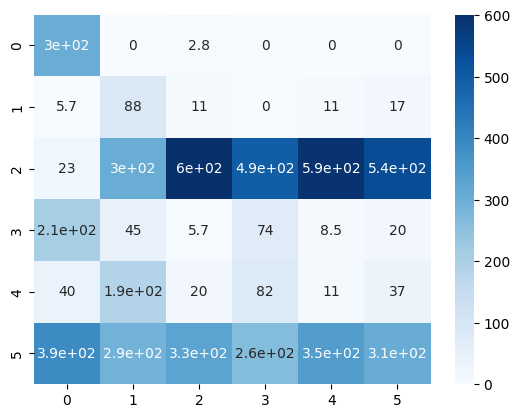

In [ ]:
encoder.eval()

labels = get_tensor(all_X0_test) 
y_tr = encoder(labels)
y_tr_rotated = rotate_all(y_tr).repeat(6,1,1)
distance_to_centroid = torch.empty(17*6, y_tr.shape[0])
for i in range(6):
    slice_distort = slice(17*i,17*(i+1))
    distance_to_centroid[slice_distort] = ((y_tr_rotated[slice_distort]- centroids[i])**2).mean(2)
min_dist = distance_to_centroid.argmin(0) // 17
del y_tr_rotated
plot_cfs_mat(min_dist.flatten(), all_y_test.astype('int')-1)
1-(1+ min_dist - all_y_test.flatten()).count_nonzero()/y_tr.shape[0]


In [ ]:
accuracies_self_supervised = []
for i in range (-15, 16):
    X_test_shift,y_test_shift = get_data(0,0, kRMS_test, 6,i)
    y_tr = encoder(get_tensor(X_test_shift) )
    y_tr_rotated = rotate_all(y_tr).repeat(6,1,1)
    distance_to_centroid = torch.empty(31*6, y_tr.shape[0])
    for j in range(6):
        slice_distort = slice(31*j,31*(j+1))
        distance_to_centroid[slice_distort] = ((y_tr_rotated[slice_distort]- centroids[j])**2).mean(2)
    min_dist = distance_to_centroid.argmin(0) // 31
    accuracies_self_supervised.append(1-(1+min_dist - y_test_shift.flatten()).count_nonzero()/y_tr.shape[0]) 
del y_tr_rotated
del y_tr

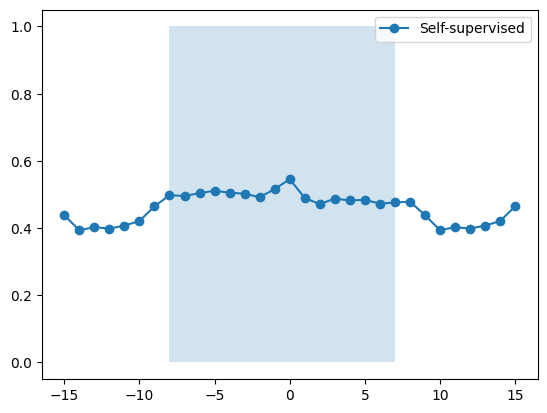

In [ ]:
plt.plot(range(-15,16),accuracies_self_supervised, '-o', label="Self-supervised")
#plt.plot(range(-15,16),accuracies_ffnn_with_all, '-s', label="FFNN,distorted")
plt.legend()
plt.fill_between(range(-8,8), 0,1, alpha=0.2)

In [ ]:
y_test_shift.flatten

<function ndarray.flatten>

In [ ]:
min_dist

tensor([1, 5, 5,  ..., 1, 1, 1])

In [ ]:
1 + min_dist - y_test_shift.flatten()

tensor([ 1.,  5.,  5.,  ..., -4., -4., -4.], dtype=torch.float64)

In [ ]:
def encoding(X_np):
    return encoder(torch.tensor(X_np)).detach().numpy()

In [ ]:
np.histogram(all_y_test, bins=[1,2,3,4,5,6, 7])

(array([5814, 5474, 5814, 5474, 5814, 5491]), array([1, 2, 3, 4, 5, 6, 7]))

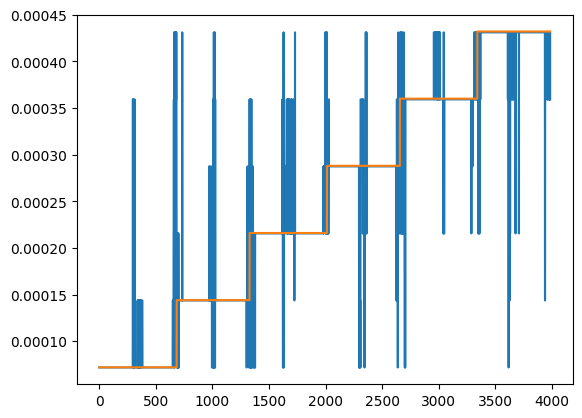

In [ ]:
prediction = reg.predict((torch.tensor(X_train)).detach().numpy())
prediction /= np.linalg.norm(prediction,1)
plt.plot(prediction)
plt.plot(y_train/ np.linalg.norm(y_train, 1))

In [ ]:
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression(random_state=0, penalty='l2', # LASSO
                                solver='liblinear', C= 100000, # Suitable for LASSO
                                max_iter=5000).fit(encoding(X_train), y_train)
reg.score(encoding(X_test),y_test)

/opt/homebrew/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.792272955343703

In [ ]:
import matplotlib.pyplot as plt

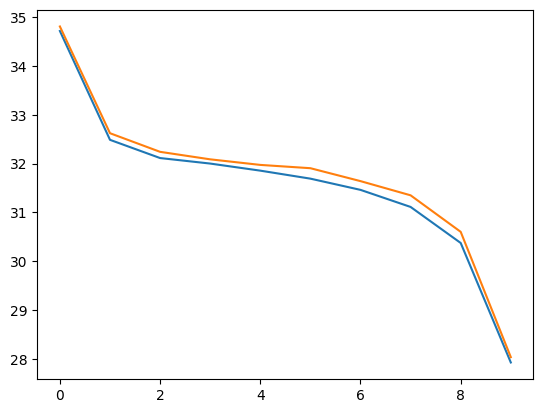

In [ ]:
import matplotlib.pyplot as plt
loss_record = [(x.cpu(), y.cpu()) for (x,y) in loss_record]
plt.plot(loss_record)